In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf 
import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

Using TensorFlow backend.


In [3]:
import os
import pandas as pd
os.chdir('C:\\Users\\Brook\\Desktop\\#SMU_Courses\\#MSDS 6130 Capstone A & B\\MSDS6120 CapstoneA\\#ProjectData&NoteBook')

Preprocessing -Transformation and Scaling 

In [4]:
print ( "Current working dir : %s" % os.getcwd())

Current working dir : C:\Users\Brook\Desktop\#SMU_Courses\#MSDS 6130 Capstone A & B\MSDS6120 CapstoneA\#ProjectData&NoteBook


In [2]:
# train = pd.read_csv('G:/SMU Data Science/SMU Courses/DS 6120 Capstone A/UNSW-NB15 Data Set/UNSW_NB15_training-set.csv')
# test = pd.read_csv('G:/SMU Data Science/SMU Courses/DS 6120 Capstone A/UNSW-NB15 Data Set/UNSW_NB15_testing-set.csv')
# list_events = pd.read_csv("G:/SMU Data Science/SMU Courses/DS 6120 Capstone A/UNSW-NB15 Data Set/UNSW-NB15_LIST_EVENTS.csv")
# features = pd.read_csv("G:/SMU Data Science/SMU Courses/DS 6120 Capstone A/UNSW-NB15 Data Set/NUSW-NB15_features.csv",encoding='latin1')


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
train = pd.read_csv(r'UNSW_NB15_training_set.csv')
test = pd.read_csv(r'UNSW_NB15_testing_set.csv')
list_events = pd.read_csv(r'UNSW_NB15_LIST_EVENTS.csv')
features = pd.read_csv(r'UNSW_NB15_features.csv',encoding='latin1')

In [7]:
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

Function to encode string features

In [8]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")
print("looks like 6 is 'normal', but its not that common")

attack cat: {'Shellcode', 'Analysis', 'Reconnaissance', 'Fuzzers', 'Exploits', 'DoS', 'Backdoor', 'Normal', 'Generic', 'Worms'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int32
mode 0.3609225646458884 %
looks like 6 is 'normal', but its not that common


In [9]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9,])

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

???? Dropping thr features of Low Standard deviation and Low corr

In [10]:
##?????
lowSTD = list(combined_data.std().to_frame().nsmallest(6,columns=0).index)
lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(3).index) # .where(lambda x: x < 0.005).dropna()
drop = set( lowCORR + lowSTD)
#drop = {'ackdat', 'ct_ftp_cmd', 'djit', 'is_ftp_login', 'is_sm_ips_ports', 'response_body_len', 'sjit', 'synack', 'tcprtt'}
combined_data.shape
combined_data_reduced=combined_data.drop(drop,axis=1)
combined_data_reduced.shape

(257673, 44)

(257673, 35)

In [11]:
pd.set_option('display.max_columns', None)
combined_data_reduced.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,swin,stcpb,dtcpb,dwin,smean,dmean,trans_depth,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,255,621772692,2202533631,255,43,43,0,1,0,1,1,1,1,0,1,1,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,255,1417884146,3077387971,255,52,1106,0,43,1,1,1,1,2,0,1,6,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,255,2116150707,2963114973,255,46,824,0,7,1,2,1,1,3,0,2,6,6,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,255,1107119177,1047442890,255,52,64,0,1,1,2,1,1,3,0,2,1,6,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,255,2436137549,1977154190,255,53,45,0,43,1,2,2,1,40,0,2,39,6,0


In [12]:
lowSTD 

['ackdat', 'synack', 'tcprtt', 'is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports']

In [13]:
#https://stats.stackexchange.com/questions/309612/removing-features-with-low-variance-in-classification-models
lowCORR

['sjit', 'response_body_len', 'djit']

In [14]:
## ??????
transform = list(combined_data_reduced.columns.values[4:])
transform

['spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'smean',
 'dmean',
 'trans_depth',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'attack_cat',
 'label']

In [15]:
transform.append('dur')
transform.remove('attack_cat')
# transform min-max norm 
combined_data_reduced[transform] = combined_data_reduced[transform].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Combined data reducd transformation

In [16]:
combined_data_reduced[transform]

,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,swin,stcpb,dtcpb,dwin,smean,dmean,trans_depth,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label,dur
0,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,0.000000,0.000000,2.879598e-04,0.000145,1.0,0.144768,0.512828,1.0,0.012838,0.028667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,2.024634e-03
1,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,0.000376,0.003087,5.916098e-04,0.000267,1.0,0.330128,0.716524,1.0,0.018919,0.737333,0.0,0.677419,0.166667,0.000000,0.000000,0.0,0.015625,0.0,0.000000,0.081967,0.0,1.083170e-02
2,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,0.000188,0.001090,2.748269e-03,0.001779,1.0,0.492706,0.689918,1.0,0.014865,0.549333,0.0,0.096774,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.081967,0.0,2.705215e-02
3,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,0.000188,0.000545,1.811945e-03,0.001563,1.0,0.257772,0.243882,1.0,0.018919,0.042667,0.0,0.000000,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.000000,0.0,2.802737e-02
4,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,0.000376,0.000182,5.659534e-04,0.001310,1.0,0.567209,0.460351,1.0,0.019595,0.030000,0.0,0.677419,0.166667,0.017241,0.017241,0.0,0.609375,0.0,0.016949,0.622951,0.0,7.490901e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,0.000000,0.000000,5.926172e-08,0.000000,0.0,0.000000,0.000000,0.0,0.018919,0.000000,0.0,0.000000,0.333333,0.017241,0.000000,0.0,0.015625,0.0,0.016949,0.000000,0.0,8.333335e-08
82328,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,0.001316,0.000182,6.623096e-04,0.002489,1.0,0.249720,0.764699,1.0,0.593919,0.029333,0.0,0.000000,0.166667,0.017241,0.000000,0.0,0.000000,0.0,0.033898,0.016393,0.0,1.843502e-02
82329,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.111492e-01,0.000000,0.0,0.000000,0.000000,0.0,0.014865,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00
82330,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.111493e-01,0.000000,0.0,0.000000,0.000000,0.0,0.014865,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00


In [17]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]

# del combined_data # free mem

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.70, random_state=42) # TODO

In [18]:
combined_data_reduced[transform].head(5)

,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,swin,stcpb,dtcpb,dwin,smean,dmean,trans_depth,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label,dur
0,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,0.000000,0.000000,0.000288,0.000145,1.0,0.144768,0.512828,1.0,0.012838,0.028667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.002025
1,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,0.000376,0.003087,0.000592,0.000267,1.0,0.330128,0.716524,1.0,0.018919,0.737333,0.0,0.677419,0.166667,0.000000,0.000000,0.0,0.015625,0.0,0.000000,0.081967,0.0,0.010832
2,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,0.000188,0.001090,0.002748,0.001779,1.0,0.492706,0.689918,1.0,0.014865,0.549333,0.0,0.096774,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.081967,0.0,0.027052
3,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,0.000188,0.000545,0.001812,0.001563,1.0,0.257772,0.243882,1.0,0.018919,0.042667,0.0,0.000000,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.000000,0.0,0.028027
4,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,0.000376,0.000182,0.000566,0.001310,1.0,0.567209,0.460351,1.0,0.019595,0.030000,0.0,0.677419,0.166667,0.017241,0.017241,0.0,0.609375,0.0,0.016949,0.622951,0.0,0.007491


In [19]:
data_x

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,swin,stcpb,dtcpb,dwin,smean,dmean,trans_depth,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst
0,2.024634e-03,113,0,4,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,0.000000,0.000000,2.879598e-04,0.000145,1.0,0.144768,0.512828,1.0,0.012838,0.028667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,1.083170e-02,113,0,4,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,0.000376,0.003087,5.916098e-04,0.000267,1.0,0.330128,0.716524,1.0,0.018919,0.737333,0.0,0.677419,0.166667,0.000000,0.000000,0.0,0.015625,0.0,0.000000,0.081967
2,2.705215e-02,113,0,4,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,0.000188,0.001090,2.748269e-03,0.001779,1.0,0.492706,0.689918,1.0,0.014865,0.549333,0.0,0.096774,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.081967
3,2.802737e-02,113,3,4,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,0.000188,0.000545,1.811945e-03,0.001563,1.0,0.257772,0.243882,1.0,0.018919,0.042667,0.0,0.000000,0.166667,0.017241,0.000000,0.0,0.031250,0.0,0.016949,0.000000
4,7.490901e-03,113,0,4,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,0.000376,0.000182,5.659534e-04,0.001310,1.0,0.567209,0.460351,1.0,0.019595,0.030000,0.0,0.677419,0.166667,0.017241,0.017241,0.0,0.609375,0.0,0.016949,0.622951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,119,0,5,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,0.000000,0.000000,5.926172e-08,0.000000,0.0,0.000000,0.000000,0.0,0.018919,0.000000,0.0,0.000000,0.333333,0.017241,0.000000,0.0,0.015625,0.0,0.016949,0.000000
82328,1.843502e-02,113,0,4,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,0.001316,0.000182,6.623096e-04,0.002489,1.0,0.249720,0.764699,1.0,0.593919,0.029333,0.0,0.000000,0.166667,0.017241,0.000000,0.0,0.000000,0.0,0.033898,0.016393
82329,0.000000e+00,6,0,5,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.111492e-01,0.000000,0.0,0.000000,0.000000,0.0,0.014865,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
82330,0.000000e+00,6,0,5,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.111493e-01,0.000000,0.0,0.000000,0.000000,0.0,0.014865,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [20]:
data_y

,label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
82327,0.0
82328,0.0
82329,0.0
82330,0.0


In [21]:
data_y.isnull().values.any()

False

In [22]:
is_all_zero = np.all((data_y == 0))
if is_all_zero:
    print('Array contains only 0')
else:
    print('Array has non-zero items too')


Array has non-zero items too


In [23]:
# after we split to 70 /30 to combine dataset

X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(77301, 33)

(77301, 1)

(180372, 33)

(180372, 1)

Benchmark before additional feature removal

In [24]:

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)


https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/

In [25]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA,TruncatedSVD,PCA
from sklearn.svm import LinearSVC
# Number of trees
n = 10

In [26]:
rfe = RFE(DecisionTreeClassifier(), n).fit(X_train,y_train)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE,X_test_RFE = X_train[whitelist],X_test[whitelist]


In [27]:
svd = TruncatedSVD(n_components=n-1).fit(X_train_RFE)   # -20 will give 0.778, in the below benchmark preditings catogories 
X_train_svd, X_test_svd = svd.transform(X_train_RFE), svd.transform(X_test_RFE)

Benchmark after additional feature removal

In [28]:
print(X_train_svd.shape)

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)
eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
        _ = eclf.fit(X_train_svd,y_train)
        pred = eclf.score(X_test_svd,y_test)
        print("Acc: %0.10f [%s]" % (pred,label))

(77301, 9)
Acc: 0.9249162841 [DecisionTreeClassifier]
Acc: 0.9245448296 [RandomForestClassifier]
Acc: 0.9244339476 [ExtraTreesClassifier]
Acc: 0.9246945202 [Ensemble]


#### Deep Learning 

We ran  SVD/PCA to remove variance since the  goal to "get the better deep learning result possible"

In [29]:
from keras.models import Sequential


In [36]:
X = X_train_svd
X_t = X_test_svd

dim = X.shape[1]
dim

9

In [37]:
X

array([[ 1.12512878e+00,  6.53306183e-01, -6.94011929e-02, ...,
        -2.33107247e-03,  9.81116273e-04, -1.98011384e-03],
       [ 3.09612232e-01,  5.60503781e-01,  3.15196061e-01, ...,
        -1.14038742e-03, -1.26766072e-03, -3.77211714e-03],
       [ 1.48159069e-01, -4.14470952e-02,  6.57337932e-02, ...,
         6.19761046e-04, -1.68180666e-03, -2.10300180e-04],
       ...,
       [ 1.11613547e+00, -3.46203497e-01,  3.90063232e-01, ...,
        -1.72464733e-04,  4.83390519e-04, -3.04442197e-04],
       [ 1.13244401e+00, -3.64932963e-01,  4.52857016e-01, ...,
        -7.09044406e-05,  3.67075576e-04, -4.34288229e-04],
       [ 1.06720984e+00, -2.90015105e-01,  2.01681889e-01, ...,
        -4.77141918e-04,  8.32342196e-04,  8.50987190e-05]])

In [38]:
X_t

array([[ 1.00741185e+00, -2.21340405e-01, -2.85619679e-02, ...,
        -8.49523392e-04,  1.25884194e-03,  5.61205620e-04],
       [ 1.02372039e+00, -2.40069870e-01,  3.42318145e-02, ...,
        -7.47963771e-04,  1.14252575e-03,  4.31359075e-04],
       [ 3.16481025e-01,  2.97326057e-01,  2.61907985e-02, ...,
        -1.08349191e-03, -2.46772017e-03, -1.05731356e-03],
       ...,
       [ 1.44152109e-01, -3.42942001e-02,  4.66198216e-02, ...,
         8.49186088e-04, -1.93461689e-03, -7.33978501e-04],
       [ 1.08424819e+00,  3.15419241e-01, -5.53768400e-02, ...,
        -1.25770186e-03, -2.64565968e-04, -1.63109384e-03],
       [ 1.08895456e+00, -3.14987725e-01,  2.85406934e-01, ...,
        -3.41728643e-04,  6.77254776e-04, -8.80296662e-05]])

In [39]:
X_v,y_v  = X_t[:X_t.shape[0]], y_test[:X_t.shape[0]]
#X_v ,y_v = X_t[:X_t.shape[0]/5], y_test[:X_t.shape[0]/5]

In [40]:
X_v

array([[ 1.00741185e+00, -2.21340405e-01, -2.85619679e-02, ...,
        -8.49523392e-04,  1.25884194e-03,  5.61205620e-04],
       [ 1.02372039e+00, -2.40069870e-01,  3.42318145e-02, ...,
        -7.47963771e-04,  1.14252575e-03,  4.31359075e-04],
       [ 3.16481025e-01,  2.97326057e-01,  2.61907985e-02, ...,
        -1.08349191e-03, -2.46772017e-03, -1.05731356e-03],
       ...,
       [ 1.44152109e-01, -3.42942001e-02,  4.66198216e-02, ...,
         8.49186088e-04, -1.93461689e-03, -7.33978501e-04],
       [ 1.08424819e+00,  3.15419241e-01, -5.53768400e-02, ...,
        -1.25770186e-03, -2.64565968e-04, -1.63109384e-03],
       [ 1.08895456e+00, -3.14987725e-01,  2.85406934e-01, ...,
        -3.41728643e-04,  6.77254776e-04, -8.80296662e-05]])

In [42]:
y_v

,label
122637,1.0
137118,1.0
69948,0.0
45921,1.0
31408,0.0
...,...
41336,0.0
62840,1.0
10166,0.0
46085,1.0


In [43]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_svd = mms.fit_transform(X_train_svd)
X_test_svd = mms.transform(X_test_svd)

In [44]:
X_train_svd

array([[0.83591508, 0.77700479, 0.23341554, ..., 0.21195972, 0.03936197,
        0.01955469],
       [0.22937495, 0.71553852, 0.51045333, ..., 0.21291539, 0.03755123,
        0.01744184],
       [0.10929422, 0.31684548, 0.33075762, ..., 0.21432812, 0.03721775,
        0.02164137],
       ...,
       [0.82922631, 0.11499469, 0.56438256, ..., 0.21369227, 0.0389612 ,
        0.02153037],
       [0.84135579, 0.10258952, 0.60961494, ..., 0.21377378, 0.03886754,
        0.02137728],
       [0.79283789, 0.15221022, 0.42868541, ..., 0.21344773, 0.03924218,
        0.02198966]])

https://keras.io/guides/sequential_model/

The Keras library provides wrapper classes to allow you to use neural network models developed with Keras in scikit-learn.There is a KerasClassifier class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
https://forums.fast.ai/t/multiclass-classification-using-dense-layers/216/5
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

Define The Neural Network Model

In [53]:
import tensorflow
layers = tensorflow.keras.layers
BatchNormalization = tensorflow.keras.layers.BatchNormalization
Conv2D = tensorflow.keras.layers.Conv2D
Flatten = tensorflow.keras.layers.Flatten
TensorBoard = tensorflow.keras.callbacks.TensorBoard
ModelCheckpoint = tensorflow.keras.callbacks.ModelCheckpoint

In [54]:

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(18, activation='relu', input_dim=dim))

classifier.add(Dense(36, activation='relu'))
classifier.add(Dropout(0.07))
classifier.add(Dense(18, activation='relu' ))
classifier.add(Dropout(0.07))
classifier.add(Dense(9, activation='relu'))

classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [59]:
tensorboard = TensorBoard(histogram_freq=0, write_graph=True)
    
    
tensorboard = TensorBoard(log_dir=f".\logs\MODEL", histogram_freq=1,write_grads=True)

In [60]:
history = classifier.fit(X,y_train, batch_size=16, epochs=15, validation_data=(X_t,y_test) , callbacks=[tensorboard]).history

Train on 77301 samples, validate on 180372 samples


AttributeError: 'Sequential' object has no attribute '_get_distribution_strategy'

In [49]:
#pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(classifier)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           9
               Dense   XXXXX -------------------       180    10.5%
                relu   #####          18
               Dense   XXXXX -------------------       684    40.0%
                relu   #####          36
             Dropout    | || -------------------         0     0.0%
                       #####          36
               Dense   XXXXX -------------------       666    38.9%
                relu   #####          18
             Dropout    | || -------------------         0     0.0%
                       #####          18
               Dense   XXXXX -------------------       171    10.0%
                relu   #####           9
               Dense   XXXXX -------------------        10     0.6%
             sigmoid   #####           1


In [50]:
eval_model=classifier.evaluate(X, y_train )
print(eval_model)


77301/77301 [==============================] - 1s 19us/step
[0.16332139045887195, 0.9220837950706482]


In [51]:
#https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1
eval_model=classifier.evaluate(X_t, y_test)
print(eval_model)


180372/180372 [==============================] - 3s 19us/step
[0.16721475939225594, 0.9204033613204956]


In [52]:
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
predictions=classifier.predict(X_t)
predictions =(predictions>0.5)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [45]:
mse = np.mean(np.power(X_test_svd - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test.values.reshape(1,-1)[0]})
# error_df.describe()
print()
print(np.mean(mse))
#cm = confusion_matrix(y_test, y_pred)

#print(cm)

25767/25767 [==============================] - 0s 13us/step
[0.17402590271901813, 0.9223037362098694]
231906/231906 [==============================] - 3s 13us/step
[0.18170148080055817, 0.9181177020072937]

0.39401580129872066


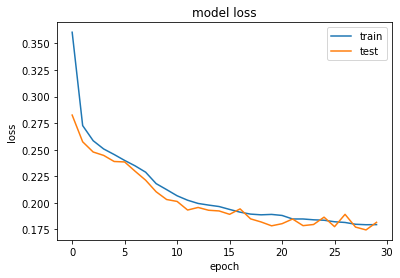

In [46]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

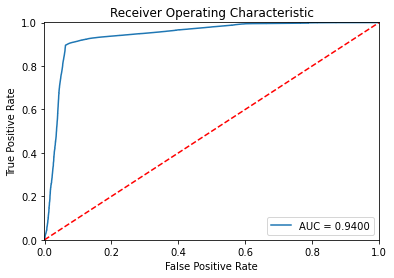

In [47]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Text(0.5, 1.0, 'Recall vs Precision')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

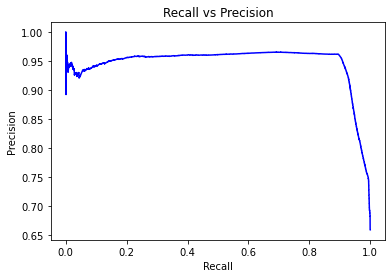

In [48]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

https://www.hindawi.com/journals/complexity/2019/6516253/